# Demo: Building Variational Autoencoders in Pytorch

Adapted from: https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/VAE_mnist.ipynb

By: Jacob Cybulski<br>
Date: July 2023<br>
Comment: *Lots of bugs fixed, works with Torch 2, on both CPU and GPU*

Adapted From: Eugenia Anello, Variational Autoencoder with Pytorch, Dataseries (Medium)<br>
Date: Jun 28, 2021

In [1]:
!pip list | grep -e qiskit -e torch

qiskit                        0.45.2
qiskit-aer-gpu                0.13.2
qiskit-algorithms             0.2.2
qiskit-dynamics               0.4.3
qiskit-experiments            0.5.4
qiskit-finance                0.4.0
qiskit-ibm-experiment         0.4.4
qiskit-ibm-provider           0.8.0
qiskit-ibm-runtime            0.18.0
qiskit-ibmq-provider          0.20.2
qiskit-machine-learning       0.7.1
qiskit-nature                 0.7.1
qiskit-optimization           0.6.0
qiskit-terra                  0.45.2
torch                         2.0.1+cu118
torchaudio                    2.0.2+cu118
torchsummary                  1.5.1
torchvision                   0.15.2+cu118


In [2]:
import matplotlib.pyplot as plt
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE

## Prelims: Get data and create tensor data loaders

In [3]:
data_dir = '../dataset'
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform

# Set the test transform
test_dataset.transform = test_transform

In [5]:
m=len(train_dataset)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

## 1.Define Encoder and Decoder classes

In [6]:
class VariationalEncoder(nn.Module):
    
    def __init__(self, latent_dims):
        
        super(VariationalEncoder, self).__init__()
        
        # Create all layers
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        
        # out_width = (28+2-5)/2+1 = 27/2+1 = 13
        
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        # out_width = (14-5)/2+1 = 5
        
        # self.drop1=nn.Dropout2d(p=0.3) 
        # 6 * 6 * 16 = 576
        
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        if torch.cuda.is_available():
            self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
            self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        
        #print(x.shape)
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        
        return z

In [7]:
### Traditional decoder
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            
            # First linear layer
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        
        # Apply linear layers
        x = self.decoder_lin(x)
        
        # Unflatten
        x = self.unflatten(x)
        
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [8]:
class VariationalAutoencoder(nn.Module):
    
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

## 2.Initialize model, optimizer, loss
*Note that "d" is the size of a latent space*

In [9]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

## 3.Training

In [10]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [11]:
### Testing function
def test_epoch(vae, device, dataloader):
    
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            
            # Move tensor to the proper device
            x = x.to(device)
            
            # Encode data
            encoded_data = vae.encoder(x)
            
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [12]:
def plot_ae_outputs(encoder,decoder,n=5):
    
    plt.figure(figsize=(10,4.5))
    
    for i in range(n):
        
        ax = plt.subplot(2,n,i+1)
        img = test_dataset[i][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()

        with torch.no_grad():
            rec_img  = decoder(encoder(img))

        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  

        if i == n//2:
            ax.set_title('Original images')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
            
    plt.show()   

	 partial train loss (single batch): 69575.375000
	 partial train loss (single batch): 67563.617188
	 partial train loss (single batch): 65966.296875
	 partial train loss (single batch): 64571.523438
	 partial train loss (single batch): 63280.289062
	 partial train loss (single batch): 62332.007812
	 partial train loss (single batch): 61265.570312
	 partial train loss (single batch): 60646.132812
	 partial train loss (single batch): 59856.445312
	 partial train loss (single batch): 59156.910156
	 partial train loss (single batch): 58661.054688
	 partial train loss (single batch): 58226.402344
	 partial train loss (single batch): 57664.394531
	 partial train loss (single batch): 57216.636719
	 partial train loss (single batch): 56794.484375
	 partial train loss (single batch): 56378.375000
	 partial train loss (single batch): 55769.140625
	 partial train loss (single batch): 55554.074219
	 partial train loss (single batch): 55301.054688
	 partial train loss (single batch): 54820.269531


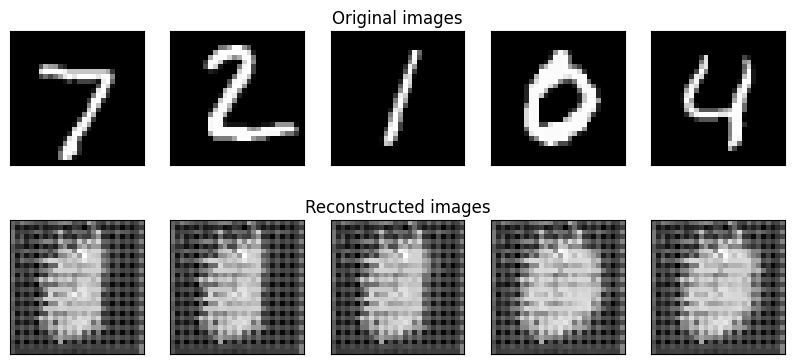

	 partial train loss (single batch): 19835.976562
	 partial train loss (single batch): 20054.015625
	 partial train loss (single batch): 19769.441406
	 partial train loss (single batch): 19576.753906
	 partial train loss (single batch): 19771.025391
	 partial train loss (single batch): 19520.792969
	 partial train loss (single batch): 19562.666016
	 partial train loss (single batch): 19490.085938
	 partial train loss (single batch): 19538.392578
	 partial train loss (single batch): 19160.255859
	 partial train loss (single batch): 19216.541016
	 partial train loss (single batch): 19136.554688
	 partial train loss (single batch): 19223.757812
	 partial train loss (single batch): 19015.746094
	 partial train loss (single batch): 19133.470703
	 partial train loss (single batch): 18960.896484
	 partial train loss (single batch): 18854.642578
	 partial train loss (single batch): 18981.111328
	 partial train loss (single batch): 18696.343750
	 partial train loss (single batch): 18563.814453


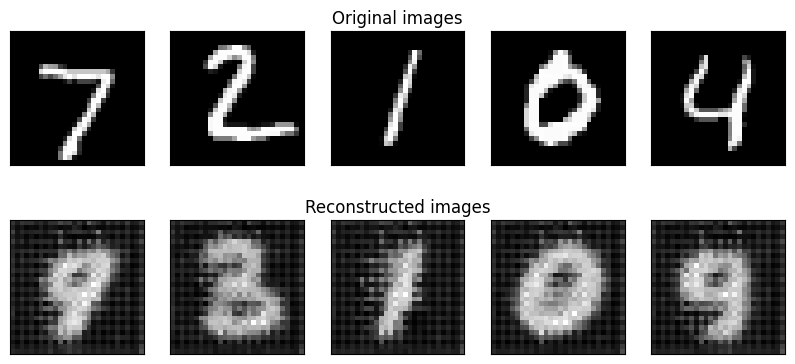

	 partial train loss (single batch): 12888.215820
	 partial train loss (single batch): 13430.454102
	 partial train loss (single batch): 13125.120117
	 partial train loss (single batch): 13024.913086
	 partial train loss (single batch): 13301.681641
	 partial train loss (single batch): 13007.349609
	 partial train loss (single batch): 13133.665039
	 partial train loss (single batch): 13188.517578
	 partial train loss (single batch): 13103.427734
	 partial train loss (single batch): 12872.011719
	 partial train loss (single batch): 12788.880859
	 partial train loss (single batch): 12825.426758
	 partial train loss (single batch): 13004.517578
	 partial train loss (single batch): 12904.535156
	 partial train loss (single batch): 13130.593750
	 partial train loss (single batch): 12842.418945
	 partial train loss (single batch): 13046.875000
	 partial train loss (single batch): 13162.003906
	 partial train loss (single batch): 12714.931641
	 partial train loss (single batch): 12750.920898


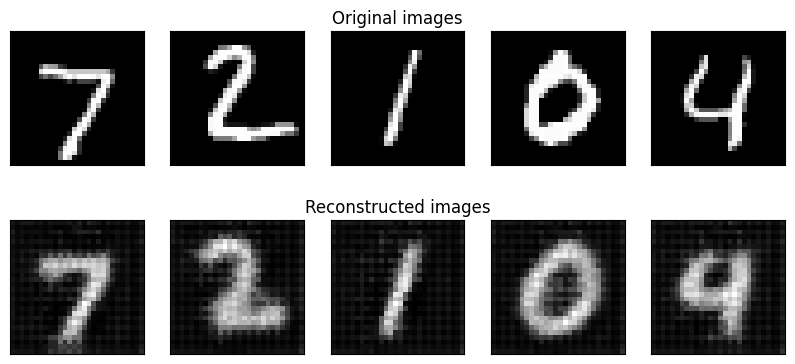

	 partial train loss (single batch): 10372.739258
	 partial train loss (single batch): 10956.472656
	 partial train loss (single batch): 10587.688477
	 partial train loss (single batch): 10741.970703
	 partial train loss (single batch): 10877.001953
	 partial train loss (single batch): 10690.649414
	 partial train loss (single batch): 10817.390625
	 partial train loss (single batch): 10839.503906
	 partial train loss (single batch): 10886.727539
	 partial train loss (single batch): 10639.098633
	 partial train loss (single batch): 10411.881836
	 partial train loss (single batch): 10506.367188
	 partial train loss (single batch): 10771.973633
	 partial train loss (single batch): 10751.640625
	 partial train loss (single batch): 10876.876953
	 partial train loss (single batch): 10644.056641
	 partial train loss (single batch): 10741.198242
	 partial train loss (single batch): 10791.990234
	 partial train loss (single batch): 10351.128906
	 partial train loss (single batch): 10472.716797


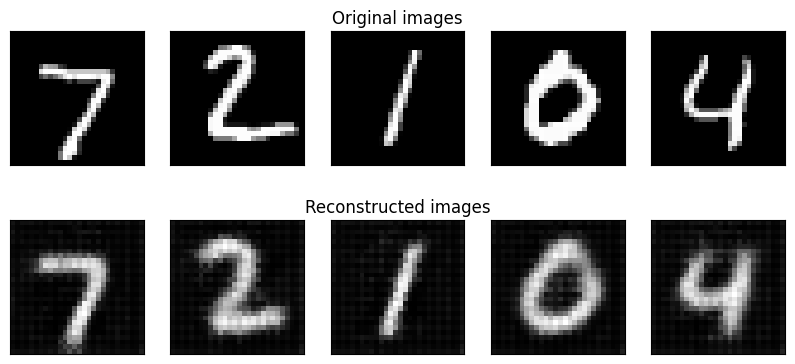

	 partial train loss (single batch): 9575.652344
	 partial train loss (single batch): 10103.057617
	 partial train loss (single batch): 9557.024414
	 partial train loss (single batch): 9935.453125
	 partial train loss (single batch): 10117.682617
	 partial train loss (single batch): 9879.035156
	 partial train loss (single batch): 10037.181641
	 partial train loss (single batch): 10150.177734
	 partial train loss (single batch): 10133.967773
	 partial train loss (single batch): 9815.908203
	 partial train loss (single batch): 9485.273438
	 partial train loss (single batch): 9831.458984
	 partial train loss (single batch): 9926.511719
	 partial train loss (single batch): 9985.987305
	 partial train loss (single batch): 10106.174805
	 partial train loss (single batch): 9794.822266
	 partial train loss (single batch): 9897.042969
	 partial train loss (single batch): 10042.840820
	 partial train loss (single batch): 9685.156250
	 partial train loss (single batch): 9778.060547
	 partial tra

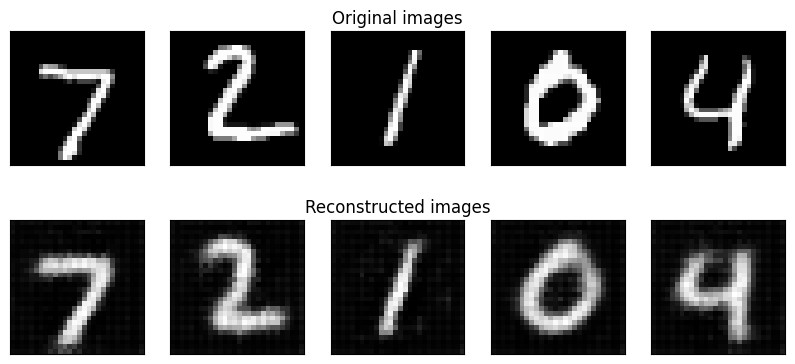

	 partial train loss (single batch): 9082.497070
	 partial train loss (single batch): 9588.759766
	 partial train loss (single batch): 9198.576172
	 partial train loss (single batch): 9536.457031
	 partial train loss (single batch): 9683.027344
	 partial train loss (single batch): 9428.925781
	 partial train loss (single batch): 9728.045898
	 partial train loss (single batch): 9685.143555
	 partial train loss (single batch): 9710.037109
	 partial train loss (single batch): 9491.251953
	 partial train loss (single batch): 9134.146484
	 partial train loss (single batch): 9352.050781
	 partial train loss (single batch): 9597.515625
	 partial train loss (single batch): 9631.265625
	 partial train loss (single batch): 9748.755859
	 partial train loss (single batch): 9507.082031
	 partial train loss (single batch): 9492.350586
	 partial train loss (single batch): 9639.562500
	 partial train loss (single batch): 9237.113281
	 partial train loss (single batch): 9324.478516
	 partial train loss

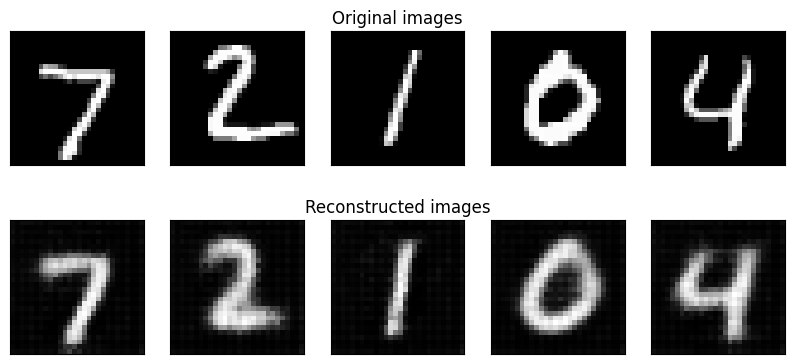

	 partial train loss (single batch): 8838.806641
	 partial train loss (single batch): 9471.295898
	 partial train loss (single batch): 8981.033203
	 partial train loss (single batch): 9284.068359
	 partial train loss (single batch): 9581.190430
	 partial train loss (single batch): 9115.930664
	 partial train loss (single batch): 9505.448242
	 partial train loss (single batch): 9537.140625
	 partial train loss (single batch): 9506.298828
	 partial train loss (single batch): 9260.310547
	 partial train loss (single batch): 8881.823242
	 partial train loss (single batch): 9158.142578
	 partial train loss (single batch): 9311.959961
	 partial train loss (single batch): 9311.708984
	 partial train loss (single batch): 9611.105469
	 partial train loss (single batch): 9279.855469
	 partial train loss (single batch): 9283.233398
	 partial train loss (single batch): 9374.568359
	 partial train loss (single batch): 9151.237305
	 partial train loss (single batch): 9102.443359
	 partial train loss

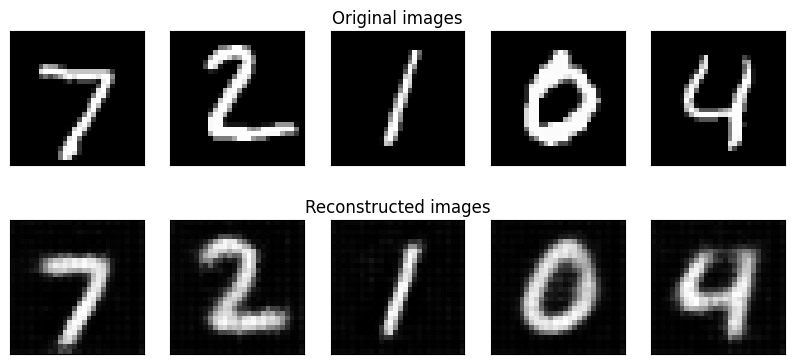

	 partial train loss (single batch): 8599.159180
	 partial train loss (single batch): 9296.580078
	 partial train loss (single batch): 8819.675781
	 partial train loss (single batch): 9079.285156
	 partial train loss (single batch): 9299.933594
	 partial train loss (single batch): 9119.226562
	 partial train loss (single batch): 9264.085938
	 partial train loss (single batch): 9344.361328
	 partial train loss (single batch): 9356.276367
	 partial train loss (single batch): 9122.844727
	 partial train loss (single batch): 8788.919922
	 partial train loss (single batch): 8923.886719
	 partial train loss (single batch): 9219.419922
	 partial train loss (single batch): 9195.255859
	 partial train loss (single batch): 9455.238281
	 partial train loss (single batch): 9153.465820
	 partial train loss (single batch): 9166.285156
	 partial train loss (single batch): 9270.332031
	 partial train loss (single batch): 8904.318359
	 partial train loss (single batch): 8992.736328
	 partial train loss

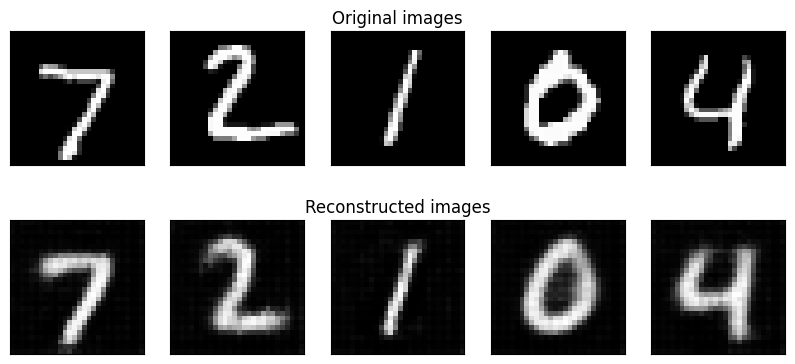

	 partial train loss (single batch): 8611.095703
	 partial train loss (single batch): 9132.136719
	 partial train loss (single batch): 8723.648438
	 partial train loss (single batch): 8934.080078
	 partial train loss (single batch): 9340.565430
	 partial train loss (single batch): 8953.045898
	 partial train loss (single batch): 9239.459961
	 partial train loss (single batch): 9264.847656
	 partial train loss (single batch): 9358.666016
	 partial train loss (single batch): 9060.598633
	 partial train loss (single batch): 8636.041016
	 partial train loss (single batch): 8963.802734
	 partial train loss (single batch): 9070.422852
	 partial train loss (single batch): 9153.078125
	 partial train loss (single batch): 9267.988281
	 partial train loss (single batch): 9022.020508
	 partial train loss (single batch): 9052.419922
	 partial train loss (single batch): 9172.084961
	 partial train loss (single batch): 8800.810547
	 partial train loss (single batch): 8811.753906
	 partial train loss

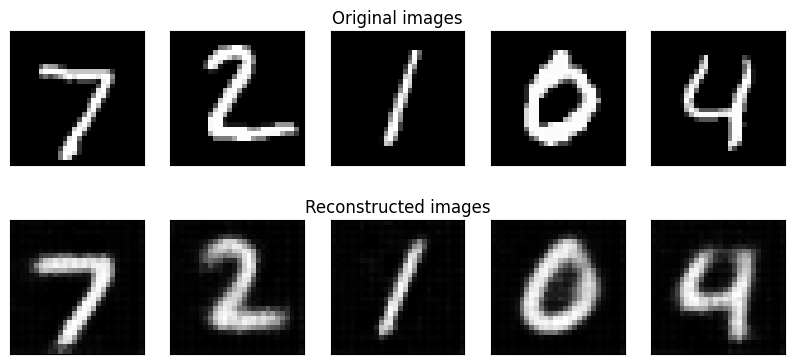

	 partial train loss (single batch): 8466.123047
	 partial train loss (single batch): 9071.289062
	 partial train loss (single batch): 8563.973633
	 partial train loss (single batch): 8793.951172
	 partial train loss (single batch): 9127.621094
	 partial train loss (single batch): 8866.579102
	 partial train loss (single batch): 9112.296875
	 partial train loss (single batch): 9185.149414
	 partial train loss (single batch): 9195.744141
	 partial train loss (single batch): 8911.796875
	 partial train loss (single batch): 8597.688477
	 partial train loss (single batch): 8828.858398
	 partial train loss (single batch): 9071.347656
	 partial train loss (single batch): 9025.149414
	 partial train loss (single batch): 9198.501953
	 partial train loss (single batch): 8926.392578
	 partial train loss (single batch): 8955.380859
	 partial train loss (single batch): 9089.636719
	 partial train loss (single batch): 8789.652344
	 partial train loss (single batch): 8723.326172
	 partial train loss

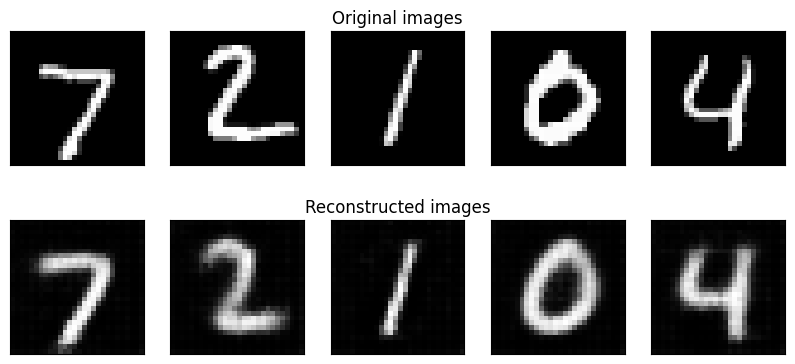

	 partial train loss (single batch): 8357.203125
	 partial train loss (single batch): 9022.695312
	 partial train loss (single batch): 8533.601562
	 partial train loss (single batch): 8910.544922
	 partial train loss (single batch): 9252.471680
	 partial train loss (single batch): 8803.035156
	 partial train loss (single batch): 8993.194336
	 partial train loss (single batch): 9118.879883
	 partial train loss (single batch): 9224.947266
	 partial train loss (single batch): 8940.764648
	 partial train loss (single batch): 8484.472656
	 partial train loss (single batch): 8867.163086
	 partial train loss (single batch): 8940.278320
	 partial train loss (single batch): 8974.384766
	 partial train loss (single batch): 9186.416016
	 partial train loss (single batch): 8808.843750
	 partial train loss (single batch): 8833.913086
	 partial train loss (single batch): 8919.458008
	 partial train loss (single batch): 8717.957031
	 partial train loss (single batch): 8697.475586
	 partial train loss

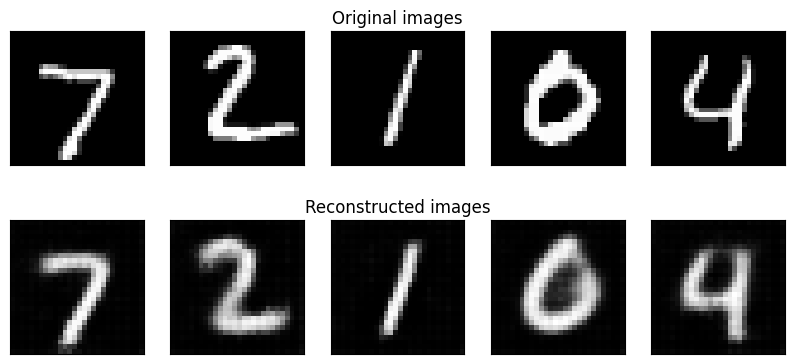

	 partial train loss (single batch): 8398.744141
	 partial train loss (single batch): 8976.683594
	 partial train loss (single batch): 8419.323242
	 partial train loss (single batch): 8697.618164
	 partial train loss (single batch): 9081.300781
	 partial train loss (single batch): 8857.233398
	 partial train loss (single batch): 9033.936523
	 partial train loss (single batch): 9060.998047
	 partial train loss (single batch): 9120.433594
	 partial train loss (single batch): 8813.927734
	 partial train loss (single batch): 8451.689453
	 partial train loss (single batch): 8810.328125
	 partial train loss (single batch): 8836.207031
	 partial train loss (single batch): 8926.655273
	 partial train loss (single batch): 9139.113281
	 partial train loss (single batch): 8728.735352
	 partial train loss (single batch): 8847.333008
	 partial train loss (single batch): 8972.869141
	 partial train loss (single batch): 8605.099609
	 partial train loss (single batch): 8591.058594
	 partial train loss

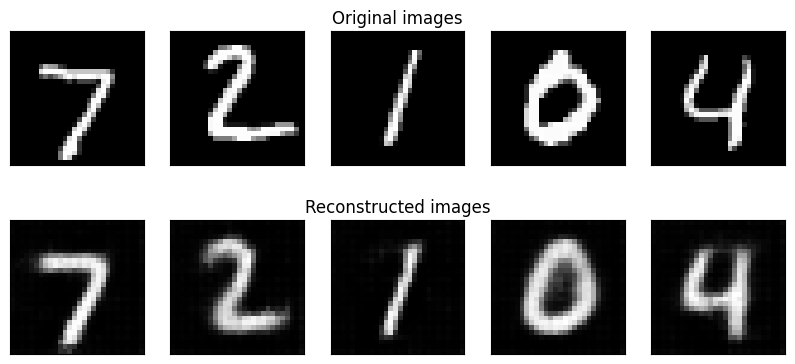

	 partial train loss (single batch): 8327.818359
	 partial train loss (single batch): 8939.206055
	 partial train loss (single batch): 8420.431641
	 partial train loss (single batch): 8683.345703
	 partial train loss (single batch): 9026.437500
	 partial train loss (single batch): 8656.083984
	 partial train loss (single batch): 8898.666992
	 partial train loss (single batch): 8977.306641
	 partial train loss (single batch): 9041.964844
	 partial train loss (single batch): 8710.347656
	 partial train loss (single batch): 8406.324219
	 partial train loss (single batch): 8716.650391
	 partial train loss (single batch): 8819.877930
	 partial train loss (single batch): 8916.373047
	 partial train loss (single batch): 9149.697266
	 partial train loss (single batch): 8671.622070
	 partial train loss (single batch): 8728.341797
	 partial train loss (single batch): 8840.071289
	 partial train loss (single batch): 8596.247070
	 partial train loss (single batch): 8524.567383
	 partial train loss

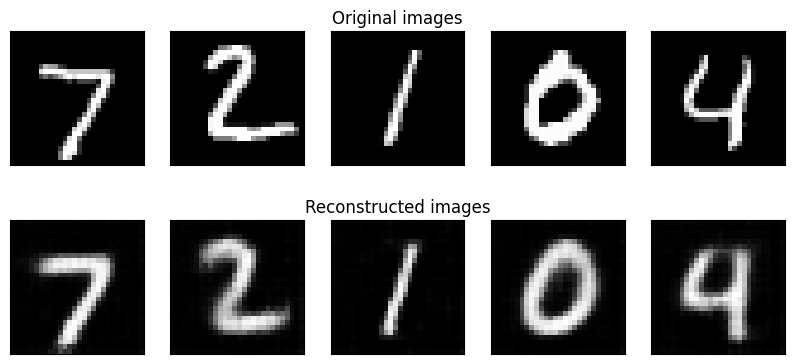

	 partial train loss (single batch): 8310.938477
	 partial train loss (single batch): 8893.755859
	 partial train loss (single batch): 8365.436523
	 partial train loss (single batch): 8720.574219
	 partial train loss (single batch): 8990.367188
	 partial train loss (single batch): 8717.132812
	 partial train loss (single batch): 8906.583984
	 partial train loss (single batch): 8900.598633
	 partial train loss (single batch): 8893.835938
	 partial train loss (single batch): 8748.420898
	 partial train loss (single batch): 8341.939453
	 partial train loss (single batch): 8655.339844
	 partial train loss (single batch): 8793.755859
	 partial train loss (single batch): 8886.137695
	 partial train loss (single batch): 9024.595703
	 partial train loss (single batch): 8655.673828
	 partial train loss (single batch): 8663.455078
	 partial train loss (single batch): 8873.757812
	 partial train loss (single batch): 8538.765625
	 partial train loss (single batch): 8496.644531
	 partial train loss

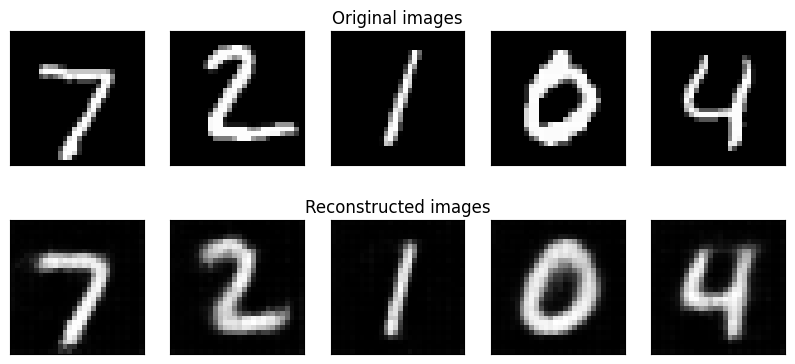

	 partial train loss (single batch): 8281.157227
	 partial train loss (single batch): 8779.183594
	 partial train loss (single batch): 8310.549805
	 partial train loss (single batch): 8591.963867
	 partial train loss (single batch): 8907.783203
	 partial train loss (single batch): 8620.586914
	 partial train loss (single batch): 8824.312500
	 partial train loss (single batch): 8902.034180
	 partial train loss (single batch): 8898.867188
	 partial train loss (single batch): 8662.390625
	 partial train loss (single batch): 8323.911133
	 partial train loss (single batch): 8580.641602
	 partial train loss (single batch): 8752.982422
	 partial train loss (single batch): 8769.351562
	 partial train loss (single batch): 8999.512695
	 partial train loss (single batch): 8635.894531
	 partial train loss (single batch): 8648.324219
	 partial train loss (single batch): 8827.780273
	 partial train loss (single batch): 8484.534180
	 partial train loss (single batch): 8464.551758
	 partial train loss

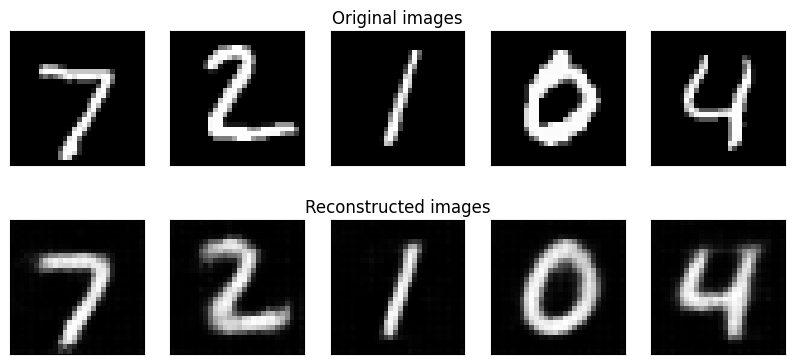

	 partial train loss (single batch): 8189.047852
	 partial train loss (single batch): 8826.576172
	 partial train loss (single batch): 8325.601562
	 partial train loss (single batch): 8569.062500
	 partial train loss (single batch): 8902.032227
	 partial train loss (single batch): 8578.058594
	 partial train loss (single batch): 8927.999023
	 partial train loss (single batch): 8801.867188
	 partial train loss (single batch): 8838.702148
	 partial train loss (single batch): 8630.351562
	 partial train loss (single batch): 8242.609375
	 partial train loss (single batch): 8624.957031
	 partial train loss (single batch): 8771.757812
	 partial train loss (single batch): 8842.448242
	 partial train loss (single batch): 8928.439453
	 partial train loss (single batch): 8576.062500
	 partial train loss (single batch): 8614.851562
	 partial train loss (single batch): 8794.641602
	 partial train loss (single batch): 8492.207031
	 partial train loss (single batch): 8472.357422
	 partial train loss

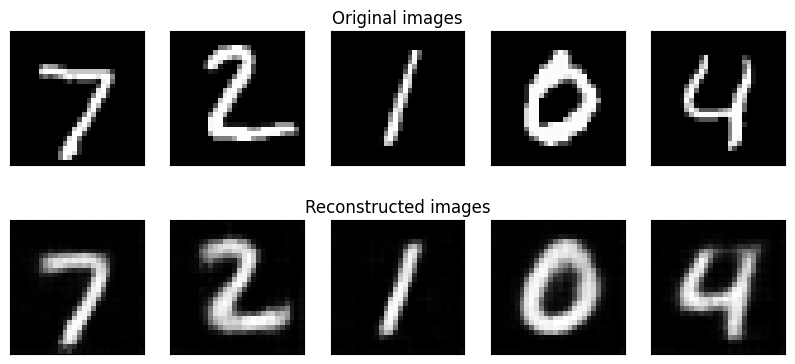

	 partial train loss (single batch): 8213.320312
	 partial train loss (single batch): 8784.176758
	 partial train loss (single batch): 8288.335938
	 partial train loss (single batch): 8567.613281
	 partial train loss (single batch): 8888.037109
	 partial train loss (single batch): 8567.529297
	 partial train loss (single batch): 8790.638672
	 partial train loss (single batch): 8860.148438
	 partial train loss (single batch): 8884.925781
	 partial train loss (single batch): 8516.281250
	 partial train loss (single batch): 8223.684570
	 partial train loss (single batch): 8609.904297
	 partial train loss (single batch): 8731.835938
	 partial train loss (single batch): 8799.211914
	 partial train loss (single batch): 8967.906250
	 partial train loss (single batch): 8491.583008
	 partial train loss (single batch): 8600.488281
	 partial train loss (single batch): 8823.962891
	 partial train loss (single batch): 8350.340820
	 partial train loss (single batch): 8465.565430
	 partial train loss

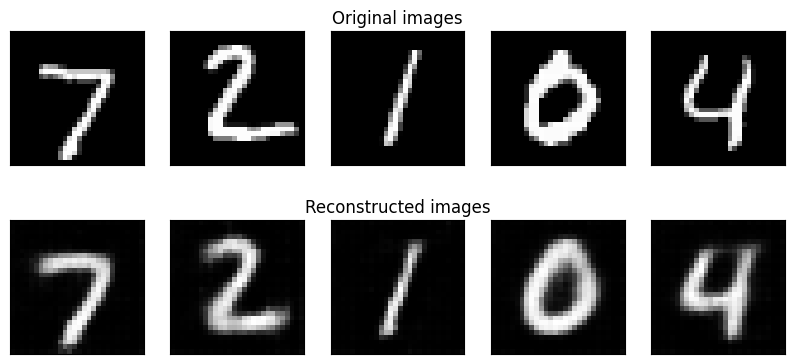

	 partial train loss (single batch): 8210.493164
	 partial train loss (single batch): 8762.375000
	 partial train loss (single batch): 8298.000000
	 partial train loss (single batch): 8493.186523
	 partial train loss (single batch): 8835.132812
	 partial train loss (single batch): 8545.635742
	 partial train loss (single batch): 8840.544922
	 partial train loss (single batch): 8794.952148
	 partial train loss (single batch): 8864.285156
	 partial train loss (single batch): 8602.724609
	 partial train loss (single batch): 8232.835938
	 partial train loss (single batch): 8592.197266
	 partial train loss (single batch): 8640.685547
	 partial train loss (single batch): 8779.276367
	 partial train loss (single batch): 8958.179688
	 partial train loss (single batch): 8490.176758
	 partial train loss (single batch): 8574.154297
	 partial train loss (single batch): 8721.646484
	 partial train loss (single batch): 8441.242188
	 partial train loss (single batch): 8350.941406
	 partial train loss

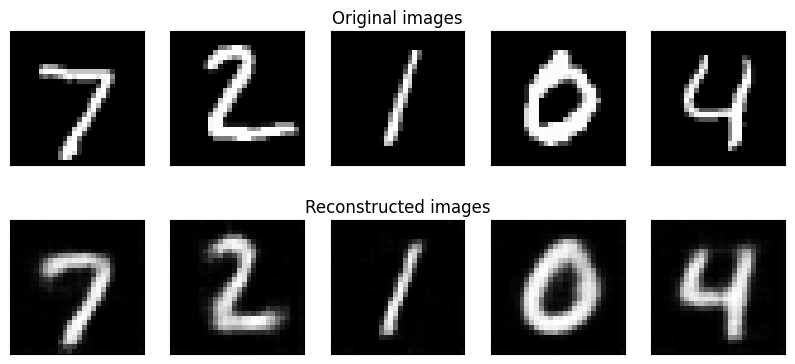

	 partial train loss (single batch): 8132.218262
	 partial train loss (single batch): 8744.205078
	 partial train loss (single batch): 8320.807617
	 partial train loss (single batch): 8512.578125
	 partial train loss (single batch): 8953.918945
	 partial train loss (single batch): 8564.960938
	 partial train loss (single batch): 8838.739258
	 partial train loss (single batch): 8793.806641
	 partial train loss (single batch): 8797.689453
	 partial train loss (single batch): 8511.832031
	 partial train loss (single batch): 8245.881836
	 partial train loss (single batch): 8628.850586
	 partial train loss (single batch): 8713.048828
	 partial train loss (single batch): 8790.960938
	 partial train loss (single batch): 8944.611328
	 partial train loss (single batch): 8477.234375
	 partial train loss (single batch): 8594.166016
	 partial train loss (single batch): 8697.499023
	 partial train loss (single batch): 8382.909180
	 partial train loss (single batch): 8335.275391
	 partial train loss

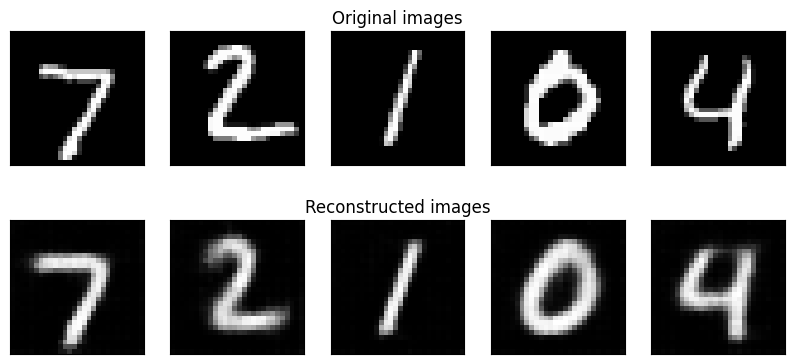

	 partial train loss (single batch): 8110.199707
	 partial train loss (single batch): 8656.224609
	 partial train loss (single batch): 8354.923828
	 partial train loss (single batch): 8472.336914
	 partial train loss (single batch): 8864.527344
	 partial train loss (single batch): 8555.375000
	 partial train loss (single batch): 8803.540039
	 partial train loss (single batch): 8792.699219
	 partial train loss (single batch): 8769.292969
	 partial train loss (single batch): 8530.234375
	 partial train loss (single batch): 8106.691895
	 partial train loss (single batch): 8631.697266
	 partial train loss (single batch): 8617.271484
	 partial train loss (single batch): 8739.171875
	 partial train loss (single batch): 8879.443359
	 partial train loss (single batch): 8462.458984
	 partial train loss (single batch): 8525.291992
	 partial train loss (single batch): 8701.446289
	 partial train loss (single batch): 8366.462891
	 partial train loss (single batch): 8335.888672
	 partial train loss

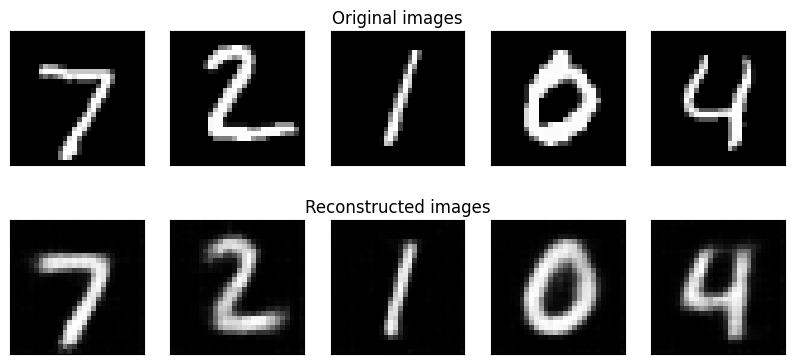

CPU times: user 1min 55s, sys: 2.2 s, total: 1min 57s
Wall time: 1min 54s


In [13]:
%%time

num_epochs = 20 # 50
history_vae={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):

    train_loss = train_epoch(vae,device,train_loader,optim)
    val_loss = test_epoch(vae,device,valid_loader)
    history_vae['train_loss'].append(train_loss)
    history_vae['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

    plot_ae_outputs(vae.encoder,vae.decoder,n=5)

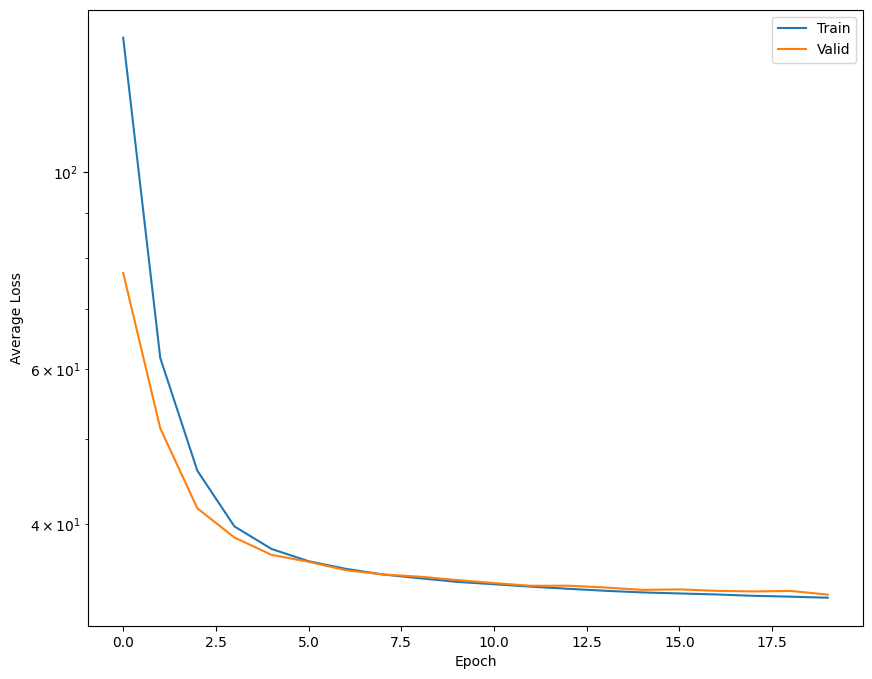

In [14]:
# Plot training performance
test_epoch(vae,device,test_loader)
plt.figure(figsize=(10,8))
plt.semilogy(history_vae['train_loss'], label='Train')
plt.semilogy(history_vae['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

## 4.Visualize latent space

100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1326.41it/s]


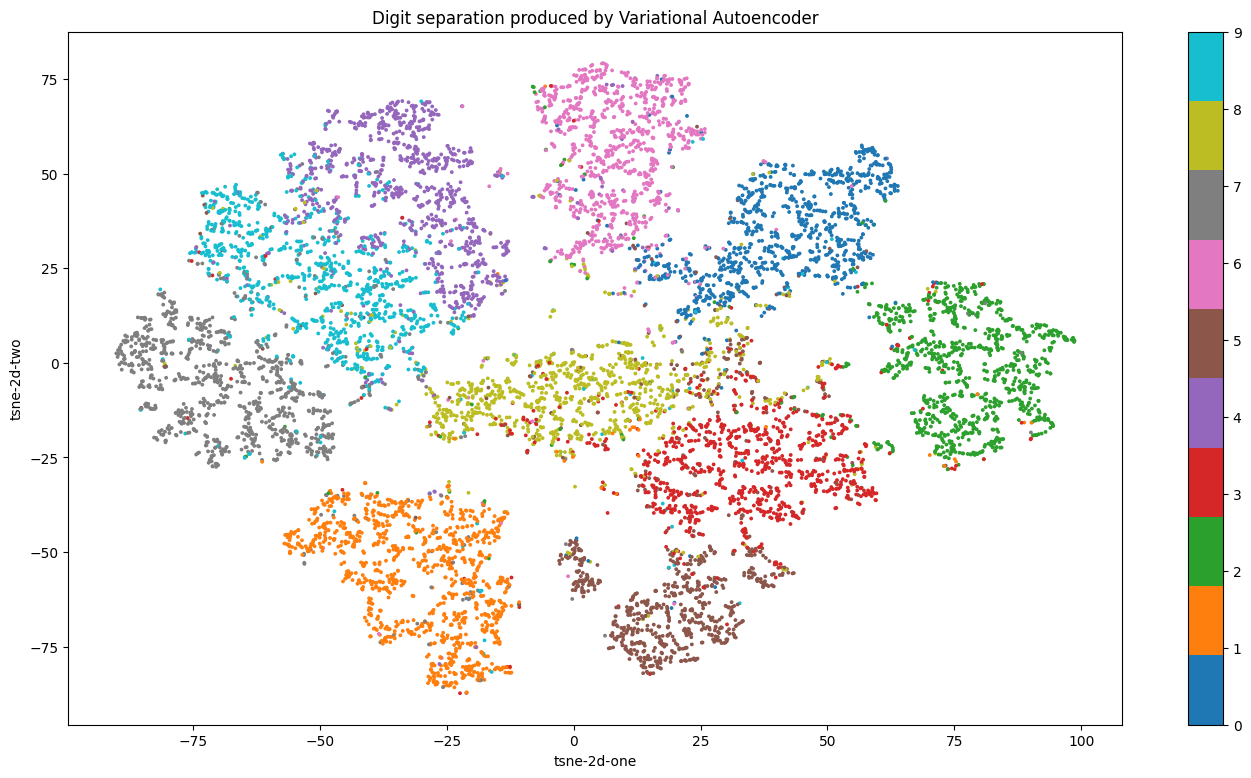

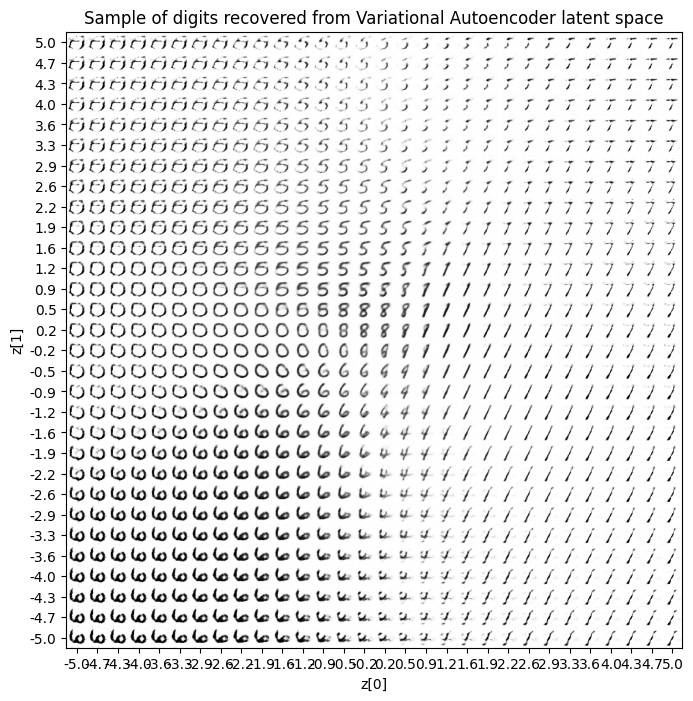

In [15]:
def plot_results(model, data, rx=(-5, 5), ry=(-5, 5), model_name='VAE'):

    # Encode all data samples
    encoded_samples = []
    for sample in tqdm(data):
        
        # Separate image data from its label 
        img = sample[0].unsqueeze(0).to(device)
        label = sample[1]
        
        # Encode image
        vae.eval()
        with torch.no_grad():
            encoded_img  = model.encoder(img)
        
        # Append to list
        encoded_img = encoded_img.flatten().cpu().numpy()
        encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
        encoded_sample['label'] = label
        encoded_samples.append(encoded_sample)
        
        # Find latend dimension from decoded image
        latent_dim = len(encoded_img)
        
    encoded_samples = pd.DataFrame(encoded_samples)

    # Create a TSNE model and plot it
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
    
    plt.figure(figsize=(17, 9))
    plt.scatter(tsne_results[:,0], tsne_results[:,1], c=encoded_samples.label, cmap='tab10', s=3)
    plt.xlabel('tsne-2d-one')
    plt.ylabel('tsne-2d-two')
    plt.title(f'Digit separation produced by {model_name}')
    plt.colorbar()
    plt.show()
    
    # Prepare a n x n 2D matrix of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # Create a linearly spaced coordinates of 2D digit classes in latent space
    grid_x = np.linspace(*rx, n)
    grid_y = np.linspace(*ry, n)[::-1]

    # Populate the matrix with images decoded from latent space
    for i, yi in enumerate(grid_y):
        for j, xj in enumerate(grid_x):
            # coords = [xj, yi, 0, 0] # Use latent_dim
            coords = list(np.zeros(latent_dim))
            coords[0] = xj
            coords[1] = yi
            z = torch.Tensor([coords]).to(device)
            x_hat = model.decoder(z)
            digit = x_hat.reshape(digit_size, digit_size).to('cpu').detach().numpy()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    # Plot the matrix of "fake" sample digits
    plt.figure(figsize=(8, 8))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title(f'Sample of digits recovered from {model_name} latent space')
    plt.imshow(figure, cmap='Greys')
    # plt.savefig(filename)
    plt.show()

plot_results(vae, test_dataset, rx=(-5, 5), ry=(-5, 5), model_name="Variational Autoencoder")

In [16]:
import qiskit.tools.jupyter
%qiskit_version_table